In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

plt.rcParams.update({'font.size': 12})

# Figure 3
## Subject embedding closes the gap between subject-specific and group models

In [6]:
# check the structure of excel_data.txt to see what data should be supplied here
# essentially each column is a different model and each row is a different subject
# please see the examples section of the readme in this repo for how to
# train these models and extract subject-level accuracies
path_to_accuracy_data = 'excel_data.txt'
df = pd.read_csv(path_to_accuracy_data, sep="\t", header=0)
df = df.stack().reset_index()

columns = {'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'}
df = df.rename(columns=columns)

# add a column for model type, i.e. subject, group, or group embedding
model_type = []
for i in range(len(df)):
    if 'finetuned' in df['model'][i]:
        model_type.append('finetuned')
    elif 'emb' in df['model'][i]:
        model_type.append('group\nembedding')
    elif 'group' in df['model'][i]:
        model_type.append('group')
    else:
        model_type.append('subject')
df['model type'] = model_type

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lin-subject vs. nonlin-subject: t-test paired samples, P_val:5.736e-04 t=4.428e+00
nonlin-group finetuned vs. nonlin-group-emb finetuned: t-test paired samples, P_val:1.326e-05 t=-6.534e+00
nonlin-group-emb vs. nonlin-group-emb finetuned: t-test paired samples, P_val:1.127e-06 t=-8.135e+00
nonlin-group vs. nonlin-group-emb: t-test paired samples, P_val:1.911e-06 t=-7.773e+00
lin-subject vs. nonlin-group-emb: t-test paired samples, P_val:1.285e-02 t=2.850e+00
lin-subject vs. nonlin-group-emb finetuned: t-test paired samples, P_val:1.066e-03 t=-4.108e+00


(<AxesSubplot:ylabel='Validation accuracy'>,
  <statannotations.Annotation.Annotation at 0x7eff852fcdf0>])

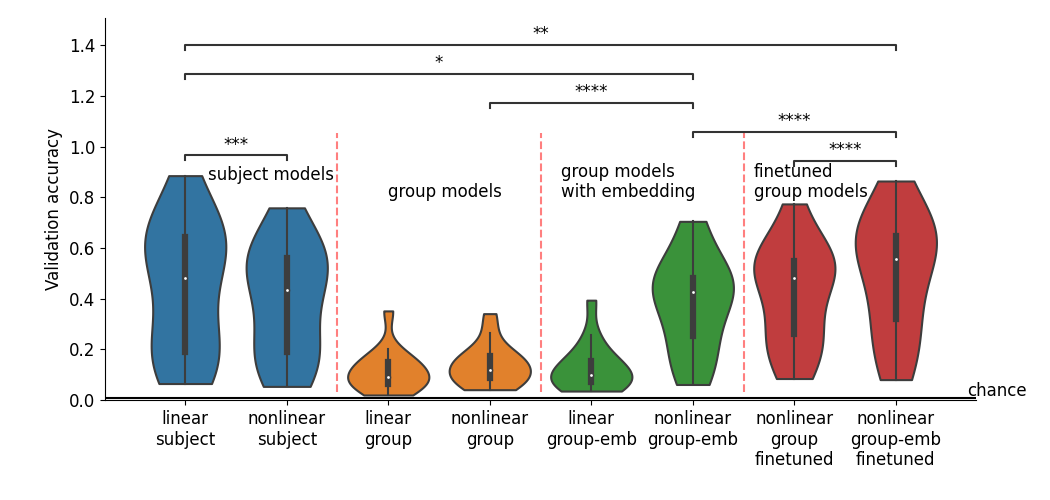

In [7]:
%matplotlib widget
# all plotting parameters
plot_params = {
    'kind':    'violin',
    'aspect':  2.1,
    'cut':     0,
    'ci':      None,
    'scale':   'area',
    'hue':     'model type',
    'dodge':   False,
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)
ax = g.axes[0][0]

# chance level in cichy118 data is 1/118 = 0.008
ax.axhline(0.008, ls='-', color='black', label='chance')

plt.ylim(0, 1)
plt.xlabel('')
plt.text(7.7,0.015,'chance')

# specify model names on x-axis
plt.xticks(plt.xticks()[0], ['linear\nsubject',
                             'nonlinear\nsubject',
                             'linear\ngroup',
                             'nonlinear\ngroup',
                             'linear\ngroup-emb',
                             'nonlinear\ngroup-emb',
                             'nonlinear\ngroup\nfinetuned',
                             'nonlinear\ngroup-emb\nfinetuned'])

# add extra padding below plot and to the left of the y-axis
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)

# add lines to separate subject, group, and group embedding models
ymin = 0.02
ymax = 0.7
alpha = 0.5
dash = '--'
color = 'red'
ax.axvline(1.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(3.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(5.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
plt.text(0.22,0.87,'subject models')
plt.text(2,0.8,'group models')
plt.text(3.7,0.8,'group models\nwith embedding')
plt.text(5.6,0.8,'finetuned\ngroup models')

# which pairs to computer stats on
pairs = [('lin-subject', 'nonlin-subject'),
         ('lin-subject', 'nonlin-group-emb'),
         ('lin-subject', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group-emb finetuned'),
         ('nonlin-group finetuned', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='t-test_paired',
                    verbose=True,
                    line_offset_to_group=10).apply_and_annotate()

# Figure 5a
## Leave-one-subject-out evaluation

In [76]:
# this path should point to the validation accuracy of the subject models
# across all training ratios: 0.1, 0.2, ..., 1.0
# please see the examples section of the readme in this repo for how to
# train these models across different training ratios
path = os.path.join('..', 'results', 'cichy_epoched', 'indiv_wavenetlinear_MNN', 'val_loss_general.npy')
accs = np.load(path)

# this is just a hack to include the results with training ratio 1.0
# as my code does did not save the results for this ratio
train1 = [0.591525424, 0.303672316, 0.121468925, 0.680790966, 0.885593221, 0.662429377, 0.730225995, 0.159604517, 0.579096052, 0.627118642, 0.223163842, 0.151129942, 0.06497175, 0.483050848, 0.412429377]
accs = np.concatenate((accs, np.array(train1).reshape(-1, 1)), axis=1)

# include the chance level
chance = [0.00847] * 15
accs = np.concatenate((np.array(chance).reshape(-1, 1), accs), axis=1)

In [77]:
# create a dataframe for plotting the subject models
accs_df = pd.DataFrame(accs)
accs_df = accs_df.stack().reset_index()

columns = {'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'}
accs_df = accs_df.rename(columns=columns)

# these correspond to the linear subject results in the paper
accs_df['level'] = ['linear subject'] * len(accs_df)

In [ ]:
# helper function to create the dataframe for the group models
def create_df(accsg, level):
    # because of the way the data is saved, we need to reorder the subjects
    order = [10, 7, 3, 11, 8, 4, 12, 9, 5, 13, 1, 14, 2, 6, 0]
    accsg_df = pd.DataFrame(accsg[order, :])
    accsg_df = accsg_df.stack().reset_index()

    columns = {'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'}
    accsg_df = accsg_df.rename(columns=columns)
    accsg_df['level'] = [level] * len(accsg_df)
    
    return accsg_df

In [ ]:
# load LOSO results for nonlinear group-emb
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group_emb = create_df(accsg, 'nonlinear group-emb')

# load LOSO results for nonlinear group
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group = create_df(accsg, 'nonlinear group')

In [ ]:
# concatenate the dataframes
df = pd.concat((accs_df, group_emb, group), ignore_index=True)

In [ ]:
# compute the p-values between group models across training ratios
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group-emb')]

    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

# most training ratios are not significant between group models
print(p_values)

# compute the p-values between subject and group-emb model across training ratios
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'linear subject')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group-emb')]

    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

# up to 70% of the training ratios are significant between subject and group-emb models
# as discussed in the paper
print(p_values)

In [ ]:
# divide the training ratio by 10 to get the actual ratio for plotting
df['Training ratio'] = df['Training ratio'].astype(float)/10

In [ ]:
%matplotlib widget
# create figure in paper
g = sns.relplot(
    data=df, kind="line", hue='level',
    x="Training ratio", y="Validation accuracy", n_boot=1000, aspect=1.2, ci=95
)
ax = g.axes[0][0]
plt.axhline(0.6, 0.02, 0.7, color='black')
plt.text(0,0.61,'nonlinear group>linear subject (p<0.05)')
plt.ylim(0, 0.6)
plt.xlabel('Training set ratio')

# chance level for cichy118 data
ax.axhline(0.008, ls='-', color='black', label='chance')
ax.legend(loc='upper left')

# Figure 5b: Temporal PFI

In [ ]:
# this path should point to the output from running temporal PFI on the group model
# please see the examples section of the readme in this repo for how to
# run temporal PFI on a trained model
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'PFIts',
                    'val_loss_PFIts.npy')
pfits = np.load(open(path, 'rb'))
pfits = pfits[0, 0] - pfits

In [ ]:
# plot the temporal PFI
%matplotlib widget
plt.figure()
plt.plot(pfits.mean(axis=0))

# axis labels
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy loss')

# x axis ticks assuming 250 Hz sampling rate
time_range = np.arange(-48, 872, 4)
plt.xticks(np.arange(12, 230, 25), time_range[12::25])
e=0

# Spatial PFI

In [ ]:
# any Elekta data path will work here as all we need is the 
# magnetometer channel locations to populate the mne.info object
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

In [ ]:
# this path should point to the output from running spatial PFI on the group model
# please see the examples section of the readme in this repo for how to
# run spatial PFI on a trained model
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'PFIch',
                    'val_loss_PFIch1.npy')
pfi_ch1 = np.load(open(path, 'rb'))

# take mean across permutations
pfi_ch1 = np.mean(pfi_ch1, axis=0)
pfi_ch1 = pfi_ch1[0, 0] - pfi_ch1[:, 1:]

In [ ]:
# create the evoked object from the spatial PFI results
evoked_ch1 = mne.EvokedArray(pfi_ch1.T, raw.info, tmin=0)

In [ ]:
%matplotlib widget
# plot topo map of spatial PFI
evoked_ch1.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=1,
                        units='Accuracy loss',
                        time_format='',
                        vmin=0)